In [1]:
import pandas as pd
from transformers import DistilBertTokenizer, TFDistilBertModel
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

import nltk
import random
from nltk.corpus import wordnet
import seaborn as sns
import matplotlib.pyplot as plt

nltk.download('wordnet')

tf.config.threading.set_intra_op_parallelism_threads(10)  # Number of threads within an individual op
tf.config.threading.set_inter_op_parallelism_threads(4)  # Number of threads across ops


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Utilizador\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Load labeled dataset
train_path = './train.txt' 
df = pd.read_csv(train_path, sep='\t', names=['title', 'from', 'genre', 'director', 'plot'])
df.drop(['title', 'from', 'director'], axis=1, inplace=True)

In [3]:
plot_genre_count = df.groupby(['plot', 'genre']).size().reset_index(name='count')

overall_genre_counts = df['genre'].value_counts().reset_index()
overall_genre_counts.columns = ['genre', 'total_count']

# Merge the overall genre counts with the plot-genre counts
plot_genre_count_with_total = pd.merge(plot_genre_count, overall_genre_counts, on='genre')

# Sort by Plot, then by Count (descending), and in case of tie, by Total_Count (ascending)
plot_genre_count_sorted = plot_genre_count_with_total.sort_values(['plot', 'count', 'total_count'], ascending=[True, False, True])

# Group by Plot and take the first row based on count of plot-genre and genre-total genre count relationships
df = plot_genre_count_sorted.groupby('plot').first().reset_index()

# Drop unnecessary columns
df.drop(['count', 'total_count'], axis=1, inplace=True)

In [4]:
# Load unlabeled test set
test_path = './test_no_labels.txt'
test_df = pd.read_csv(test_path, sep='\t', names=['title', 'from', 'director', 'plot'])
test_df.drop(['title', 'from', 'director'], axis=1, inplace=True)

In [5]:
# Features and target
X = df['plot']
y = df['genre']

In [6]:
# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [7]:
# Split dataset into training (64%), validation (16%), and test sets (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=777)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=777)  # 55% of 36% goes to test

In [8]:
# Map NLTK POS tags to WordNet POS tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None
    
# Get synonyms that match the part of speech of the word
def get_synonyms(word, pos):
    synonyms = set()
    
    for syn in wordnet.synsets(word, pos=pos):  # Only use synonyms with matching POS
        for lemma in syn.lemmas():
            # Exclude the word itself from the list of synonyms
            if lemma.name().lower() != word.lower():
                synonyms.add(lemma.name().replace('_', ' '))  # Convert underscores to spaces
    
    return list(synonyms)

def synonym_replacement(text, n):
    words = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(words)  # Get POS tags for each word
    new_words = words.copy()
    
    # Filter for only alphanumeric words and their part-of-speech tags
    random_word_list = list(set([(word, get_wordnet_pos(tag)) for word, tag in pos_tags if word.isalnum() and get_wordnet_pos(tag)]))
    
    # Determine the number of words to replace based on the percentage `n`
    num_words_to_replace = max(1, int(len(random_word_list) * n))  # Ensure at least one word is replaced
    
    random.shuffle(random_word_list)  # Shuffle for randomness
    num_replaced = 0
    
    for random_word, pos in random_word_list:
        synonyms = get_synonyms(random_word, pos)  # Get synonyms matching the POS
        
        if synonyms:  # Replace only if there are synonyms available
            synonym = random.choice(synonyms)
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        
        if num_replaced >= num_words_to_replace:  # Stop when the desired number of replacements is reached
            break
    
    return ' '.join(new_words)

X_train_augmented = X_train.copy()
X_train_augmented = X_train_augmented.apply(lambda plot: synonym_replacement(plot, n=0.6))
X_train_combined = pd.concat([X_train, X_train_augmented])
y_train_combined = np.concatenate([y_train, y_train])

In [9]:
# Pre-trained DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
model.trainable = True

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [10]:
def preprocess_text(texts, max_len=256):
    # Tokenizing the text with truncation, padding, and returning tensors as needed
    encoding = tokenizer(
        texts.tolist(),
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors="tf"
    )
    return {'input_ids': encoding['input_ids'], 'attention_mask': encoding['attention_mask']}

In [11]:
# Tokenize the train, validation, and test sets
X_train_tokens = preprocess_text(X_train_combined)
print('done train')
X_val_tokens = preprocess_text(X_val)
print('done val')
X_test_tokens = preprocess_text(X_test)
print('done test')

done train
done val
done test


In [12]:
# Build the model with DistilBERT as the base
input_ids = tf.keras.layers.Input(shape=(256,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input(shape=(256,), dtype=tf.int32, name='attention_mask')
bert_output = model(input_ids, attention_mask=attention_mask)[0][:, 0, :]

In [13]:
dense1 = tf.keras.layers.Dense(256, activation='relu')(bert_output)
dropout1 = tf.keras.layers.Dropout(0.3)(dense1)
dense2 = tf.keras.layers.Dense(128, activation='relu')(dropout1)
dropout2 = tf.keras.layers.Dropout(0.3)(dense2)
output = tf.keras.layers.Dense(len(df['genre'].unique()), activation='softmax')(dropout2)

In [14]:
# Define the classifier model
classifier_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

In [15]:
# Compile the model
classifier_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])

In [16]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

In [17]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_combined), y=y_train_combined)
class_weight_dict = dict(enumerate(class_weights))

In [18]:
tf.config.threading.set_intra_op_parallelism_threads(10)  # Number of threads within an individual op
tf.config.threading.set_inter_op_parallelism_threads(4)  # Number of threads across ops
# Train the model
history = classifier_model.fit(
    {'input_ids': X_train_tokens['input_ids'], 'attention_mask': X_train_tokens['attention_mask']},
    y_train_combined,
    validation_data=({'input_ids': X_val_tokens['input_ids'], 'attention_mask': X_val_tokens['attention_mask']}, y_val),
    epochs=5,
    batch_size=16,
    callbacks=[early_stopping, model_checkpoint],
    class_weight=class_weight_dict
)

Epoch 1/5


698/698 [==============================] - ETA: 0s - loss: 1.3697 - accuracy: 0.4653

E:\Mestrado\LN\ProjetoLN\.venv\Lib\site-packages\tf_keras\src\engine\training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


698/698 [==============================] - 1191s 2s/step - loss: 1.3697 - accuracy: 0.4653 - val_loss: 1.1498 - val_accuracy: 0.6174
Epoch 2/5
698/698 [==============================] - 1188s 2s/step - loss: 0.8563 - accuracy: 0.6681 - val_loss: 0.9742 - val_accuracy: 0.6759
Epoch 3/5
698/698 [==============================] - 1222s 2s/step - loss: 0.5716 - accuracy: 0.7701 - val_loss: 0.9693 - val_accuracy: 0.6825
Epoch 4/5
698/698 [==============================] - 1191s 2s/step - loss: 0.3573 - accuracy: 0.8549 - val_loss: 1.0892 - val_accuracy: 0.6675
Epoch 5/5
698/698 [==============================] - 1191s 2s/step - loss: 0.2088 - accuracy: 0.9216 - val_loss: 1.3177 - val_accuracy: 0.6967


In [19]:
# Evaluate on the test set
test_results = classifier_model.evaluate(
    {'input_ids': X_test_tokens['input_ids'], 'attention_mask': X_test_tokens['attention_mask']},
    y_test
)
print(f"Test Loss: {test_results[0]}")
print(f"Test Accuracy: {test_results[1]}")

38/38 [==============================] - 40s 1s/step - loss: 1.0352 - accuracy: 0.6850
Test Loss: 1.0352377891540527
Test Accuracy: 0.6850459575653076


38/38 [==============================] - 40s 1s/step
              precision    recall  f1-score   support

      action       0.65      0.65      0.65       160
   animation       0.79      0.76      0.78        66
      comedy       0.58      0.58      0.58       165
       crime       0.56      0.61      0.58        77
       drama       0.64      0.57      0.60       254
      horror       0.80      0.86      0.83       176
     romance       0.58      0.55      0.56       128
      sci-fi       0.55      0.74      0.63        31
     western       0.91      0.96      0.93       140

    accuracy                           0.69      1197
   macro avg       0.67      0.70      0.68      1197
weighted avg       0.68      0.69      0.68      1197



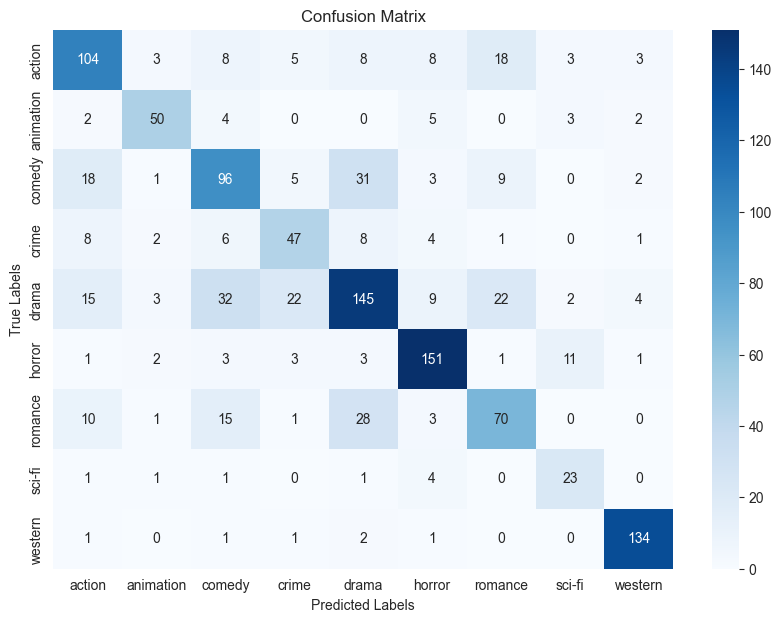

In [20]:
# Generate classification report for the test set
y_test_pred = classifier_model.predict({'input_ids': X_test_tokens['input_ids'], 'attention_mask': X_test_tokens['attention_mask']})
y_test_pred_labels = label_encoder.inverse_transform(tf.argmax(y_test_pred, axis=1))
print(classification_report(label_encoder.inverse_transform(y_test), y_test_pred_labels))


conf_matrix = confusion_matrix(y_test, tf.argmax(y_test_pred, axis=1))
genre_names = label_encoder.classes_
# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=genre_names, yticklabels=genre_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [21]:
# Prepare the unlabeled test set
X_unlabeled_tokens = preprocess_text(test_df['plot'])

# Make predictions on the unlabeled test set
predictions = classifier_model.predict(
    {'input_ids': X_unlabeled_tokens['input_ids'], 'attention_mask': X_unlabeled_tokens['attention_mask']}
)

13/13 [==============================] - 13s 1s/step


In [22]:
# Convert predictions to labels
predicted_genres = label_encoder.inverse_transform(tf.argmax(predictions, axis=1))

In [23]:
# Create a dataframe with results
results_df = pd.DataFrame({'plot': test_df['plot'], 'predicted_genre': predicted_genres})

In [24]:
# Save results to CSV
results_df.to_csv('predicted_genres.csv', index=False)
print("Predictions saved to 'predicted_genres.csv'")

# Save results to TXT
with open('predicted_genres.txt', 'w') as f:
    for genre in predicted_genres:
        f.write(genre + '\n')
print("Predictions saved to 'predicted_genres.txt'")

Predictions saved to 'predicted_genres.csv'
Predictions saved to 'predicted_genres.txt'
